<a href="https://colab.research.google.com/github/albalopezdevesa/PROYECTO-INTEGRADOR-III/blob/main/Proyecto_integrador_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO INTEGRADOR III:

## CLUSTERING

Importamos librerias

In [1]:
# Instala las bibliotecas necesarias
!pip install scikit-learn pandas category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [2]:
# Importamos librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import category_encoders as ce
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Importar la proyección en 3D

In [3]:
# Cargar el archivo Excel
data = pd.read_excel('datos_limpios.xlsx')
data.head()

,num_expediente,fecha,hora,distrito,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,...,coordenada_y_utm,positiva_alcohol,positiva_droga,fecha_hora,num_acompañantes,zona,hora_categoria,num_dia_semana,dia,festivo
0,2021S000003,2021-01-01,0.020833,MORATALAZ,Lluvia débil,Vehículos Automóviles,Conductor,De 40 a 49 años,Hombre,grave,...,4473923.981,S,0,2021-01-01 00:30:00,0,Este,Noche cerrada,4,viernes,festivo
1,2021S000003,2021-01-01,0.020833,MORATALAZ,Lluvia débil,Vehículos Automóviles,Conductor,De 40 a 49 años,Mujer,leve,...,4473923.981,S,0,2021-01-01 00:30:00,0,Este,Noche cerrada,4,viernes,festivo
2,2021S000001,2021-01-01,0.034722,USERA,Despejado,Vehículos Automóviles,Conductor,De 30 a 39 años,Mujer,leve,...,4469499.175,N,0,2021-01-01 00:50:00,0,Sur,Noche cerrada,4,viernes,festivo
3,2021S000001,2021-01-01,0.034722,USERA,Despejado,Vehículos Automóviles,Conductor,De 40 a 49 años,Hombre,ninguna,...,4469499.175,N,0,2021-01-01 00:50:00,0,Sur,Noche cerrada,4,viernes,festivo
4,2021S000005,2021-01-01,0.052083,PUENTE DE VALLECAS,Nublado,Vehículos Automóviles,Conductor,De 18 a 29 años,Hombre,ninguna,...,4470523.153,N,0,2021-01-01 01:15:00,0,Sur,Noche cerrada,4,viernes,festivo


In [4]:
# Lista de columnas a mantener
columnas_a_mantener = [col for col in data.columns if col not in ['num_expediente', 'fecha', 'hora', 'fecha_hora', 'dia', 'tipo_persona', 'coordenada_x_utm', 'coordenada_y_utm', 'distrito']]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_util = data[columnas_a_mantener]
print(df_util.head())

  estado_meteorológico          tipo_vehiculo       rango_edad    sexo  \
0         Lluvia débil  Vehículos Automóviles  De 40 a 49 años  Hombre   
1         Lluvia débil  Vehículos Automóviles  De 40 a 49 años   Mujer   
2            Despejado  Vehículos Automóviles  De 30 a 39 años   Mujer   
3            Despejado  Vehículos Automóviles  De 40 a 49 años  Hombre   
4              Nublado  Vehículos Automóviles  De 18 a 29 años  Hombre   

  lesividad positiva_alcohol  positiva_droga  num_acompañantes  zona  \
0     grave                S               0                 0  Este   
1      leve                S               0                 0  Este   
2      leve                N               0                 0   Sur   
3   ninguna                N               0                 0   Sur   
4   ninguna                N               0                 0   Sur   

  hora_categoria  num_dia_semana  festivo  
0  Noche cerrada               4  festivo  
1  Noche cerrada               4  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

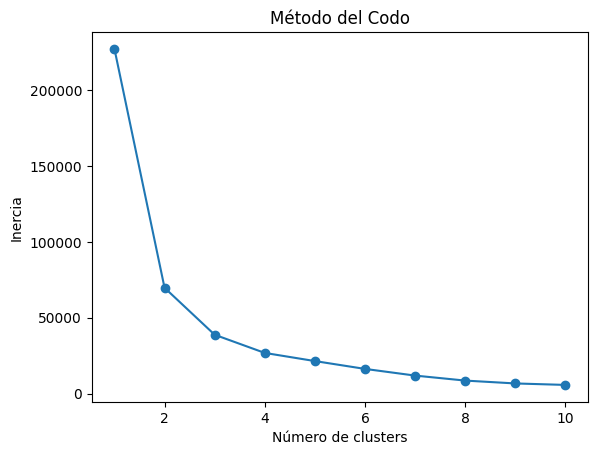

In [5]:
# Convertir variables categóricas en variables dummy (one-hot encoding)
data_encoded = pd.get_dummies(df_util)

# Eliminar cualquier columna que contenga valores no numéricos, como nombres o etiquetas
data_numeric = data_encoded.select_dtypes(include=['number'])

# Calcula la inercia para diferentes valores de k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_numeric)
    inertia.append(kmeans.inertia_)

# Visualiza la curva del codo
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

PORBAMOS CON 3 CLUSTERS Y TODAS LAS VARIABLES

In [6]:
# Codificar las variables categóricas usando one-hot encoding
df_encoded = pd.get_dummies(df_util)

# Normalizar los datos para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Elegir el número de clusters (puedes ajustarlo según tus necesidades)
num_clusters = 3

# Realizar el clustering utilizando K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_normalized)

# Agregar la columna de clusters al dataframe original
df_util['Cluster'] = clusters

# Calcular las categorías más comunes en cada cluster y sus porcentajes
cluster_info = {}
for cluster_id in range(num_clusters):
    cluster_df = df_util[df_util['Cluster'] == cluster_id]
    total_obs = len(cluster_df)
    top_categories = []
    for column in df_util.columns:
        if df_util[column].dtype == 'object' or df_util[column].dtype == 'category':  # Considerar columnas categóricas y de tipo 'category'
            top_category = cluster_df[column].value_counts().idxmax()
            top_category_count = cluster_df[column].value_counts().max()
            top_category_percentage = (top_category_count / total_obs) * 100
            top_categories.append((column, top_category, top_category_count, top_category_percentage))
        elif df_util[column].dtype == 'int32':  # Considerar columnas de tipo 'int32'
            top_value = cluster_df[column].value_counts().idxmax()
            top_value_count = cluster_df[column].value_counts().max()
            top_value_percentage = (top_value_count / total_obs) * 100
            top_categories.append((column, top_value, top_value_count, top_value_percentage))
    cluster_info[cluster_id] = {'total_obs': total_obs, 'top_categories': top_categories}


# Imprimir la información de cada cluster
for cluster_id, info in cluster_info.items():
    print(f"Cluster {cluster_id}:")
    print(f"Total de observaciones: {info['total_obs']}")
    print("Categorías más comunes:")
    for column, top_category, top_category_count, top_category_percentage in info['top_categories']:
        print(f"- {column}: {top_category} ({top_category_count} observaciones, {top_category_percentage:.2f}% del cluster)")
    print()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
Total de observaciones: 2044
Categorías más comunes:
- estado_meteorológico: Despejado (1769 observaciones, 86.55% del cluster)
- tipo_vehiculo: Vehículos Automóviles (1524 observaciones, 74.56% del cluster)
- rango_edad: De 18 a 29 años (679 observaciones, 33.22% del cluster)
- sexo: Hombre (1770 observaciones, 86.59% del cluster)
- lesividad: ninguna (1633 observaciones, 79.89% del cluster)
- positiva_alcohol: S (2044 observaciones, 100.00% del cluster)
- zona: Sur (540 observaciones, 26.42% del cluster)
- hora_categoria: Noche cerrada (590 observaciones, 28.86% del cluster)
- festivo: no festivo (1864 observaciones, 91.19% del cluster)
- Cluster: 0 (2044 observaciones, 100.00% del cluster)

Cluster 1:
Total de observaciones: 40935
Categorías más comunes:
- estado_meteorológico: Despejado (34718 observaciones, 84.81% del cluster)
- tipo_vehiculo: Vehículos Automóviles (23784 observaciones, 58.10% del cluster)
- rango_edad: De 40 a 49 años (9646 observaciones, 23.56% del cl

<ipython-input-6-5dc343902ede>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_util['Cluster'] = clusters


In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Codificar las variables categóricas usando one-hot encoding
df_encoded = pd.get_dummies(df_util)

# Normalizar los datos para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_encoded)

# Elegir el número de clusters (puedes ajustarlo según tus necesidades)
num_clusters = 3

# Realizar el clustering utilizando K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_normalized)

# Agregar la columna de clusters al dataframe original
df_util['Cluster'] = clusters

# Calcular las categorías más comunes en cada cluster y sus porcentajes
cluster_info = {}
for cluster_id in range(num_clusters):
    cluster_df = df_util[df_util['Cluster'] == cluster_id]
    total_obs = len(cluster_df)
    top_categories = []
    class_distributions = {}  # Diccionario para almacenar las distribuciones de clase de cada variable
    for column in df_util.columns:
        if df_util[column].dtype == 'object' or df_util[column].dtype == 'category':  # Considerar columnas categóricas y de tipo 'category'
            class_distributions[column] = cluster_df[column].value_counts(normalize=True) * 100
            top_category = cluster_df[column].value_counts().idxmax()
            top_category_count = cluster_df[column].value_counts().max()
            top_category_percentage = (top_category_count / total_obs) * 100
            top_categories.append((column, top_category, top_category_count, top_category_percentage))
        elif df_util[column].dtype == 'int32':  # Considerar columnas de tipo 'int32'
            class_distributions[column] = cluster_df[column].value_counts(normalize=True) * 100
            top_value = cluster_df[column].value_counts().idxmax()
            top_value_count = cluster_df[column].value_counts().max()
            top_value_percentage = (top_value_count / total_obs) * 100
            top_categories.append((column, top_value, top_value_count, top_value_percentage))
    cluster_info[cluster_id] = {'total_obs': total_obs, 'top_categories': top_categories, 'class_distributions': class_distributions}


# Imprimir la información de cada cluster
for cluster_id, info in cluster_info.items():
    print(f"Cluster {cluster_id}:")
    print(f"Total de observaciones: {info['total_obs']}")
    print("Categorías más comunes:")
    for column, top_category, top_category_count, top_category_percentage in info['top_categories']:
        print(f"- {column}: {top_category} ({top_category_count} observaciones, {top_category_percentage:.2f}% del cluster)")
    print("\nDistribución de clases por variable:")
    for column, distribution in info['class_distributions'].items():
        print(f"- {column}:")
        print(distribution)
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-13ff8db282f8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_util['Cluster'] = clusters


Cluster 0:
Total de observaciones: 40935
Categorías más comunes:
- estado_meteorológico: Despejado (34718 observaciones, 84.81% del cluster)
- tipo_vehiculo: Vehículos Automóviles (23784 observaciones, 58.10% del cluster)
- rango_edad: De 40 a 49 años (9646 observaciones, 23.56% del cluster)
- sexo: Hombre (40935 observaciones, 100.00% del cluster)
- lesividad: ninguna (31852 observaciones, 77.81% del cluster)
- positiva_alcohol: N (40935 observaciones, 100.00% del cluster)
- zona: Centro (10430 observaciones, 25.48% del cluster)
- hora_categoria: Tarde (10308 observaciones, 25.18% del cluster)
- festivo: no festivo (39090 observaciones, 95.49% del cluster)
- Cluster: 0 (40935 observaciones, 100.00% del cluster)

Distribución de clases por variable:
- estado_meteorológico:
estado_meteorológico
Despejado         84.812508
Nublado            7.362892
Lluvia débil       6.009527
LLuvia intensa     1.661170
Nevando            0.134359
Granizando         0.019543
Name: proportion, dtype: fl

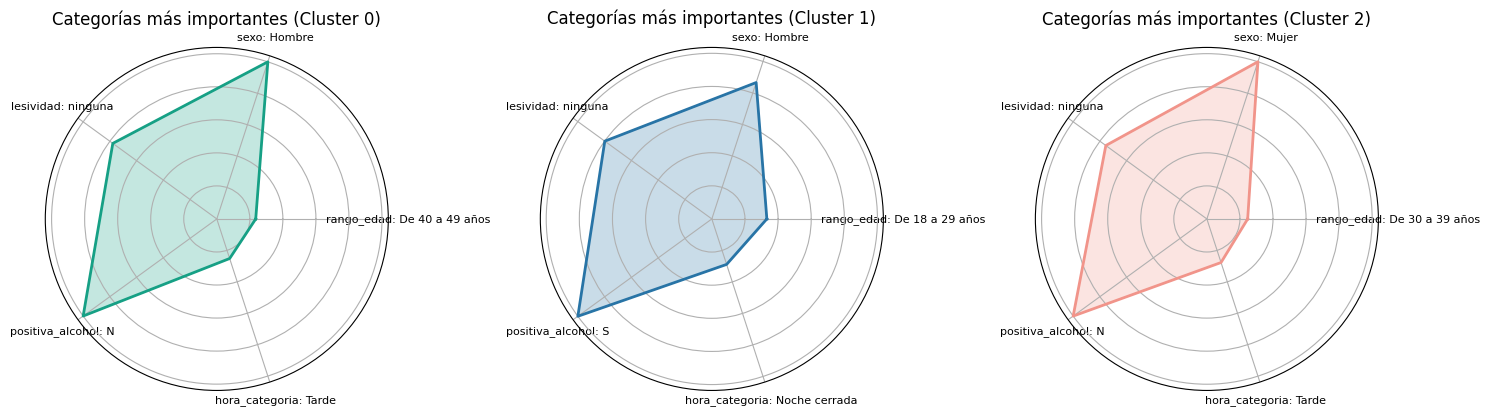

In [9]:
# Lista de colores para cada cluster
colors = ['#16A085', '#2874A6', '#F1948A']

# Variables que deseas mostrar en los radar charts
variables_a_mostrar = ['sexo', 'rango_edad', 'positiva_alcohol', 'distrito', 'num_dia_semana', 'hora_categoria', 'lesividad']

# Función para generar radar chart con etiquetas de categorías
def radar_chart(ax, categories, values, cluster_id, color):
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)  # Ajusta el tamaño de las etiquetas
    ax.set_title(f'Categorías más importantes (Cluster {cluster_id})')

# Crear una fila de subplots para los 3 radar charts
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5), subplot_kw=dict(polar=True))

# Iterar sobre cada cluster y generar un radar chart para cada uno
for cluster_id in range(num_clusters):
    categories = [f"{entry[0]}: {entry[1]}" for entry in cluster_info[cluster_id]['top_categories'] if entry[0] in variables_a_mostrar]
    values = [entry[3] for entry in cluster_info[cluster_id]['top_categories'] if entry[0] in variables_a_mostrar]  # Porcentaje de la categoría

    # Generar el radar chart para el cluster actual en el subplot correspondiente
    radar_chart(axs[cluster_id], categories, values, cluster_id, colors[cluster_id])

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los subplots con los radar charts
plt.show()

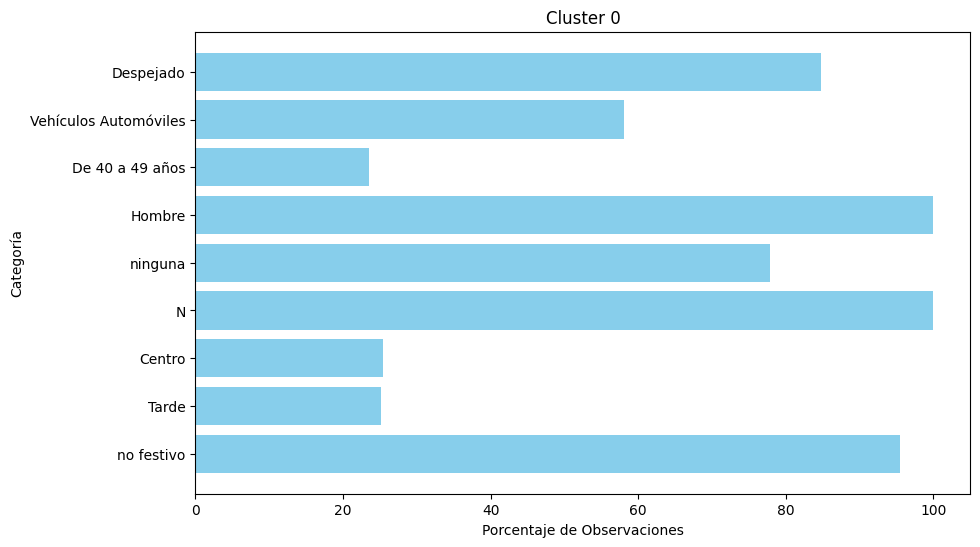

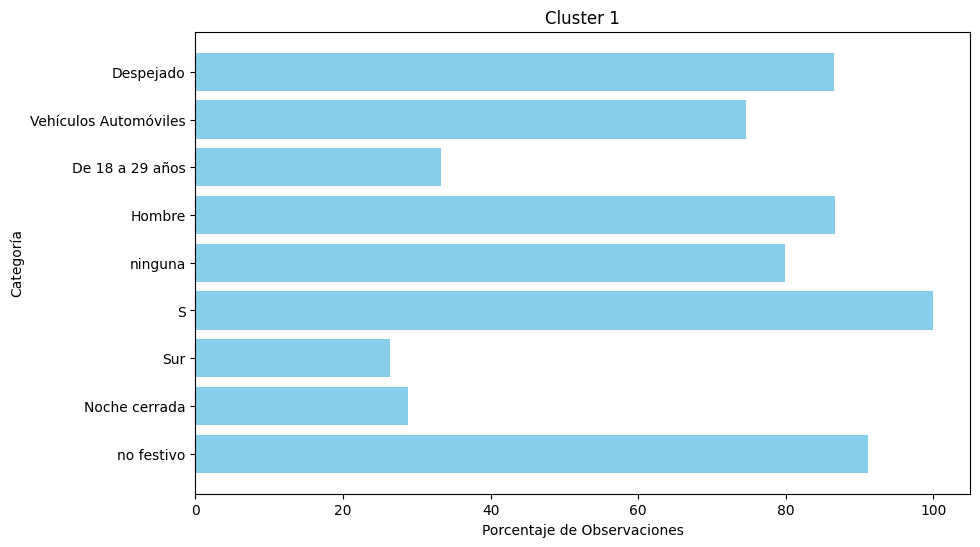

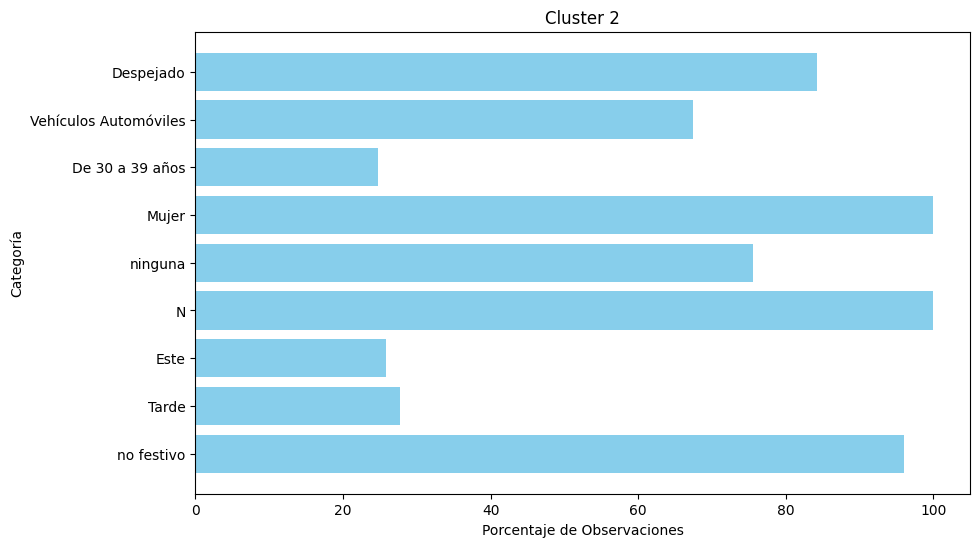

In [10]:
# Graficar la información de cada cluster
for cluster_id, info in cluster_info.items():
    categories = [x[1] for x in info['top_categories'] if isinstance(x[1], str)]  # Filtrar categorías de tipo str
    percentages = [x[3] for x in info['top_categories'] if isinstance(x[1], str)]  # Filtrar porcentajes correspondientes

    plt.figure(figsize=(10, 6))
    plt.barh(categories, percentages, color='skyblue')
    plt.xlabel('Porcentaje de Observaciones')
    plt.ylabel('Categoría')
    plt.title(f'Cluster {cluster_id}')
    plt.gca().invert_yaxis()
    plt.show()

In [11]:
pca = PCA()
principal_components = pca.fit_transform(df_normalized)

# Obtener las cargas de componentes y atributos
componentes_df = pd.DataFrame(pca.components_, columns=df_encoded.columns)
print("Cargas de componentes para cada atributo:")
print(componentes_df)

# Explorar la varianza explicada por cada componente principal
varianza_explicada = pca.explained_variance_ratio_
print("\nVarianza explicada por cada componente principal:")
for i, var in enumerate(varianza_explicada):
    print(f"Componente {i+1}: {var:.2f}")

Cargas de componentes para cada atributo:
    positiva_droga  num_acompañantes  num_dia_semana       Cluster  \
0     5.031312e-02      1.270507e-03    6.991825e-02 -5.468457e-01   
1    -1.908286e-02     -2.032754e-03    1.019668e-02  4.428683e-03   
2     5.201557e-02     -1.014441e-02    9.539279e-02  6.368663e-02   
3    -4.322334e-02     -1.868561e-02   -1.032875e-01 -4.212447e-03   
4     2.685585e-02     -2.648378e-02   -1.438345e-04 -2.130067e-03   
5     2.740914e-02     -3.652990e-03   -8.448909e-02 -8.679299e-02   
6     5.553064e-02      4.868098e-03   -1.853435e-01  3.751510e-03   
7    -1.057619e-02     -1.395051e-02   -1.353869e-02  8.423403e-03   
8     2.821614e-02      3.201142e-02   -8.924871e-02 -2.356654e-02   
9     4.554444e-02      9.054373e-03   -2.728272e-02 -9.134210e-03   
10   -2.613244e-03      2.687043e-03   -3.340479e-02 -6.736073e-03   
11    2.397658e-02      5.566198e-03    9.586317e-02  2.054209e-02   
12    1.668219e-02     -5.274267e-03    1.392511

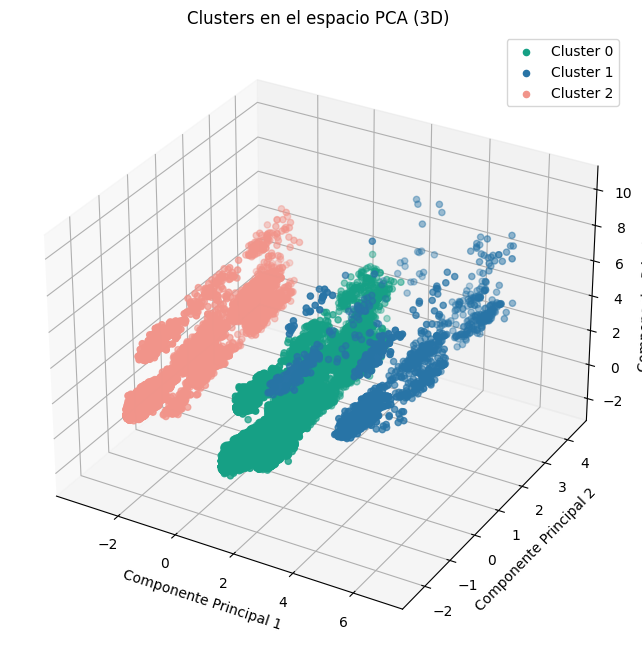

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # Importar la proyección en 3D
import matplotlib.pyplot as plt

# Aplicar PCA a los datos normalizados, pero ahora con 3 componentes principales
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(df_normalized)

# Crear un nuevo DataFrame con las componentes principales y el cluster asignado
df_pca_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['Cluster'] = clusters

# Definir colores para cada cluster
cluster_colors = ['#16A085', '#2874A6', '#F1948A']  # Puedes ajustar los colores según tus preferencias

# Crear la figura tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los clusters en el espacio tridimensional
for cluster_id in range(num_clusters):
    cluster_data = df_pca_3d[df_pca_3d['Cluster'] == cluster_id]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')

# Configurar el título y etiquetas de los ejes
ax.set_title('Clusters en el espacio PCA (3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.legend()

# Mostrar el gráfico
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


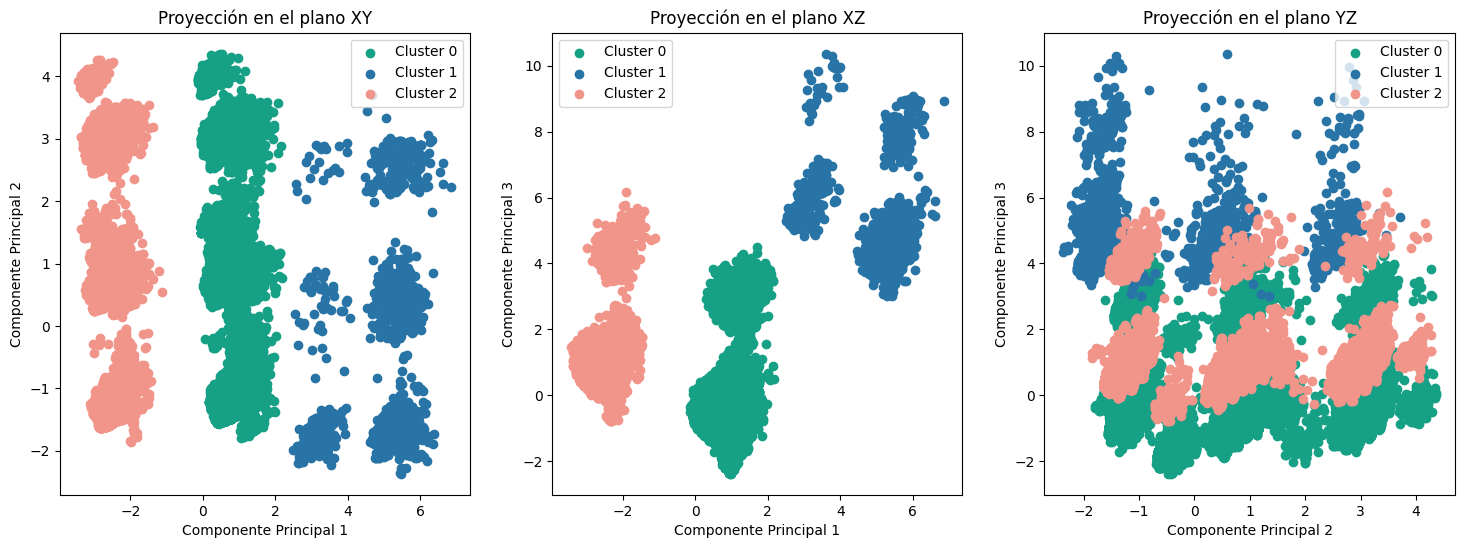

In [16]:
# Definir colores personalizados para cada cluster
cluster_colors = ['#16A085', '#2874A6', '#F1948A']

# Crear las figuras y subgráficos para las proyecciones en los planos XY, XZ y YZ
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Proyección en el plano XY
for cluster_id in range(num_clusters):
    cluster_data = df_pca_3d[df_pca_3d['Cluster'] == cluster_id]
    axs[0].scatter(cluster_data['PC1'], cluster_data['PC2'], c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')
axs[0].set_title('Proyección en el plano XY')
axs[0].set_xlabel('Componente Principal 1')
axs[0].set_ylabel('Componente Principal 2')
axs[0].legend()

# Proyección en el plano XZ
for cluster_id in range(num_clusters):
    cluster_data = df_pca_3d[df_pca_3d['Cluster'] == cluster_id]
    axs[1].scatter(cluster_data['PC1'], cluster_data['PC3'], c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')
axs[1].set_title('Proyección en el plano XZ')
axs[1].set_xlabel('Componente Principal 1')
axs[1].set_ylabel('Componente Principal 3')
axs[1].legend()

# Proyección en el plano YZ
for cluster_id in range(num_clusters):
    cluster_data = df_pca_3d[df_pca_3d['Cluster'] == cluster_id]
    axs[2].scatter(cluster_data['PC2'], cluster_data['PC3'], c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')
axs[2].set_title('Proyección en el plano YZ')
axs[2].set_xlabel('Componente Principal 2')
axs[2].set_ylabel('Componente Principal 3')
axs[2].legend()

# Mostrar los gráficos
plt.show()